# Continuous Control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

## Start the environment!
**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Randomly Pick Actions

In the next piece of code cell, controlling the agent and receiving feedback from the environment is shown.

In the environment you started above, once the cell is executed, the agent will start interacting with the environment.

In [4]:
class DizzyArm:
    __MAX_TIMESTEPS = 2000

    def __init__(self, env, num_episodes, train_mode=True):
        """
        Initialize the dizzy agent.

        Args:
            env (UnityEnvironment): Environment to interact with.
            num_episodes (int): Number of episodes to run.
            train_mode (bool): Should be true if train mode is desired.
        """
        env_info = env.reset(train_mode=train_mode)[brain_name]

        self.env = env
        self.train_mode = train_mode
        self.num_episodes = num_episodes
        self.action_size = brain.vector_action_space_size
        self.num_agents = len(env_info.agents)
        self.states = env_info.vector_observations

    def start(self):
        """
        Train/Test the dizzy agent.

        Note:
            This agent is called dizzy as it takes random actions to interact with the environment.
            It does not learn from the environment as it does not use the states and rewards from it.
            It just saves the reward and hopes it has a good one.

            This is just for illustrative purposes.
        """
        averaged_scores = []
        for i in range(0, self.num_episodes):
            _ = self.env.reset(train_mode=self.train_mode)[brain_name]
            scores = np.zeros(self.num_agents)

            for t in range(DizzyArm.__MAX_TIMESTEPS):
                actions = np.random.randn(self.num_agents, self.action_size)
                actions = np.clip(actions, -1, 1)
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                dones = env_info.local_done
                scores += env_info.rewards
                self.states = next_states

                averaged_scores.append(np.mean(scores))

                if np.any(dones):
                    break

            print(f'\rEpisode {i}\tScore: {np.mean(scores)}', end='')

        print(f'\rAverage score {np.mean(averaged_scores):.2f}', end='')

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.plot(np.arange(len(scores)), [np.mean(scores)] * len(scores))
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        ax.legend(['Score', 'Average Score'])
        plt.show()

Average score 0.070.132999997027218354

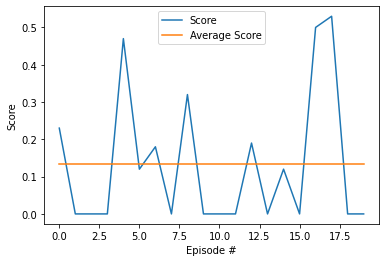

In [5]:
num_episodes = 100
dizzy_arm = DizzyArm(env, num_episodes, train_mode=True)
dizzy_arm.start()

## Actor-Critic

In [5]:
import torch
import torch.nn as nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.model = nn.Sequential(
            nn.BatchNorm1d(state_size),
            nn.Linear(state_size, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, action_size),
            nn.Tanh(),
        )

    def forward(self, state):
        return self.model(state)

In [7]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.model_1 = nn.Sequential(
            nn.BatchNorm1d(state_size),
            nn.Linear(state_size, 128),
            nn.ELU(),
        )

        self.model_2 = nn.Sequential(
            nn.Linear(128 + action_size, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, 1),
            nn.ELU(),
        )

    def forward(self, state, action):
        x_state = self.model_1(state)

        x = torch.cat((x_state, action.float()), dim=1)

        return self.model_2(x)

In [8]:
import random
from collections import namedtuple, deque

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialize a replay buffer.

        Note:
            The data structure used to save the experiences is a queue of size `buffer_size`.
            The queue is a queue of `namedtuples`.

        Args:
            action_size (int): Dimension of each action.
            buffer_size (int): Maximum size of buffer.
            batch_size (int): Size of each training batch.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

        random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to memory.

        Args:
            state (numpy.array):
            action (numpy.array):
            reward (float):
            next_state (numpy.array):
            done (bool): A flag to indicate if episode is done.
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [9]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DDPG:
    __BUFFER_SIZE = int(1e6)  # Replay buffer size
    __BATCH_SIZE = 256        # Minibatch size
    __GAMMA = 0.995           # Discount factor
    __TAU = 0.01              # For soft update of target parameters
    __LR_ACTOR = 1e-3         # Actor Learning rate
    __LR_CRITIC = 1e-3        # Critic Learning rate
    __UPDATE_EVERY = 32       # Network update rate
    __N_EPISODES = 160        # Number of episodes
    __MAX_TIMESTEPS = 1000    # Max number of timesteps per episode
    __GOAL = 35               # Goal to consider the problem solved
    __N_EXPERIENCES = 16      # Number of experiences to learn from
    __AVG_OVER = 100          # Number of scores to average over

    def __init__(self, state_size, action_size, random_seed):
        """
        Initialize a DDPG agent according to the set of states and set of actions from the environment.

        Note:
            It contains hyperparameters to tune the training stage, e.g. discount factor,
            number of epsiodes, etc.

        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            random_seed (int): Seed for random.

        Example:
            >>> dqn = DDPG(state_size=37, action_size=4, random_seed=89)
        """

        self.state_size = state_size
        self.action_size = action_size
        random.seed(random_seed)

        self.actor_regular = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_regular.parameters(), lr=DDPG.__LR_ACTOR)

        self.critic_regular = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_regular.parameters(), lr=DDPG.__LR_CRITIC)

        self.memory = ReplayBuffer(action_size, DDPG.__BUFFER_SIZE, DDPG.__BATCH_SIZE, random_seed)

        # Make a deep copy of the weights for each target and regular network
        self.deep_copy(self.actor_target, self.actor_regular)
        self.deep_copy(self.critic_target, self.critic_regular)

    def train(self, env, brain_name):
        """
        Train the agent based on the environment and brain.

        Args:
            env (UnityEnvironment): Environment to train with.
            brain_name (str): Name of the brain.

        Example:
            >>> ddpg = DDPG(37, 4, random_seed=89)
            >>> ddpg.train(UnityEnvironment(file_name='/path/to/Environment.app'), 'EnvironmentBrain')
        """
        scores_deque = deque(maxlen=DDPG.__AVG_OVER)
        global_scores = []
        averaged_scores = []

        avg_score = None

        for i_episode in range(1, DDPG.__N_EPISODES+1):
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            scores = np.zeros(len(env_info.agents))

            for t in range(DDPG.__MAX_TIMESTEPS):
                actions = self.act(states)
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                self.step(states, actions, rewards, next_states, dones, t)
                states = next_states
                scores += rewards

                if np.any(dones):
                    break

            score = np.mean(scores)
            scores_deque.append(score)
            avg_score = np.mean(scores_deque)

            global_scores.append(score)
            averaged_scores.append(avg_score)

            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}', end="")

            if i_episode % 10 == 0:
                print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}')

            if avg_score >= DDPG.__GOAL:
                print(f'\nEnvironment solved in {i_episode:d} episodes!\tAverage Score: {avg_score:.2f}')
                torch.save(self.actor_regular.state_dict(), 'actor_weights.pth')
                torch.save(self.critic_regular.state_dict(), 'critic_weights.pth')
                break

        return global_scores, avg_score

    def test(self, env, brain_name):
        """
        Test the agent based on the environment and brain.

        Args:
            env (UnityEnvironment): Environment to train with.
            brain_name (str): Name of the brain.

        Example:
            >>> dqn = DDPG(37, 4)
            >>> dqn.test(UnityEnvironment(file_name='/path/to/Environment.app'), 'EnvironmentBrain')
        """

        self.critic_regular.load_state_dict(torch.load('critic_weights.pth'))
        self.actor_regular.load_state_dict(torch.load('actor_weights.pth'))

        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations

        while True:
            actions = self.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            dones = env_info.local_done
            states = next_states

            if np.any(dones):
                break

    def step(self, states, actions, rewards, next_states, dones, timestep):
        """
        Perform a step in the training process.

        Note:
            Firstly, saves the state in the replay experience buffer (state, action, reward, next_state, done).
            If there are enough numbers of samples in the memory, just sample one of them randomly, and help
            the learning process with it.

        Args:
            states (numpy.array): The current state from which an action has been selected.
            actions (numpy.array): The action selected based on the current state.
            rewards (float): The reward obtained after applying the action.
            next_states (numpy.array): The next state to which the environment will transition after applying the action.
            dones (numpy.array): An array of bool flags indicating agents are done.
        """
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > DDPG.__BATCH_SIZE and timestep % DDPG.__UPDATE_EVERY == 0:
            for _ in range(DDPG.__N_EXPERIENCES):
                experiences = self.memory.sample()
                self.learn(experiences, DDPG.__GAMMA)

    def act(self, state):
        """
        Returns actions for given state as per current policy.

        Args:
            state (numpy.array): current state
        """
        states = torch.from_numpy(state).float().to(device)
        self.actor_regular.eval()

        with torch.no_grad():
            actions = self.actor_regular(states).cpu().data.numpy()

        self.actor_regular.train()
        return actions

    def learn(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.

        Args:
            experiences (Tuple[torch.Variable]): Tuple of (state, action, reward, next_state, done) tuples
            gamma (float): Discount factor.
        """
        states, actions, rewards, next_states, dones = experiences

        # Update the critic neural network
        # Get predicted next-state actions
        actions_next = self.actor_target(next_states)
        # Get Q values from target model
        Q_targets_next = self.critic_target(next_states, actions_next)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Calculate the critic loss
        Q_expected = self.critic_regular(states, actions)

        loss = torch.nn.MSELoss()
        critic_loss = loss(Q_expected, Q_targets.detach())

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update the actor neural network
        # Calculate the actor loss
        actions_pred = self.actor_regular(states)
        # Change sign because of the gradient descent
        actor_loss = -self.critic_regular(states, actions_pred).mean()

        # Minimize the loss function
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target network using the soft update approach (slowly updating)
        self.soft_update(self.critic_regular, self.critic_target, DDPG.__TAU)
        self.soft_update(self.actor_regular, self.actor_target, DDPG.__TAU)

    def soft_update(self, local_model, target_model, tau):
        """
        Soft update model weights.

        Note:
            θ_target = τ * θ_local + (1 - τ) * θ_target

        Args:
            local_model (nn.Model): Model to copy the weights from.
            target_model (nn.Model): Model to copy the weights to.
            tau (float): Interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau) * target_param.data)

    def deep_copy(self, target, source):
        """
        Make a deep copy of weights

        Args:
            target (nn.Model): Target model.
            source (nn.Model): Source model.
        """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [10]:
class Training:
    def start(env):
        """
        Start training.

        Note:
            Train mode should be enabled.

        Args:
            env (UnityEnvironment): Environment to train with.
        """
        env_info = env.reset(train_mode=True)[brain_name]

        action_size = brain.vector_action_space_size

        state_size = len(env_info.vector_observations[0])

        agent = DDPG(state_size, action_size, random_seed=89)
        scores, avg_score = agent.train(env, brain_name)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.plot(np.arange(len(scores)), [avg_score] * len(scores))
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        ax.legend(['Score', 'Average Score'])
        plt.show()

Episode 10	Average Score: 2.31
Episode 20	Average Score: 13.80
Episode 30	Average Score: 19.94
Episode 40	Average Score: 23.80
Episode 50	Average Score: 26.47
Episode 60	Average Score: 28.50
Episode 70	Average Score: 29.89
Episode 80	Average Score: 30.94
Episode 90	Average Score: 31.60
Episode 100	Average Score: 32.08
Episode 109	Average Score: 35.21
Environment solved in 109 episodes!	Average Score: 35.21


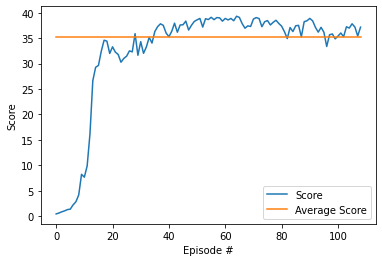

In [11]:
Training.start(env)

In [12]:
class Evaluation:
    def start(env):
        """
        Start evaluating.

        Note:
            Train mode should be disabled.

        Args:
            env (UnityEnvironment): Environment to train with.
        """
        env_info = env.reset(train_mode=False)[brain_name]
        action_size = brain.vector_action_space_size
        state_size = len(env_info.vector_observations[0])

        agent = DDPG(state_size, action_size, random_seed=89)
        agent.test(env, brain_name)

In [14]:
Evaluation.start(env)